# PDF 분석 및 라이브러리 비교 (PDF Analysis & Benchmark)

이 노트북은 다양한 PDF 처리 라이브러리(`PyMuPDF`, `PyPDF2`, `pdfplumber`)를 사용하여 PDF 파일을 분석합니다.
**알림**: 현재 환경 문제로 `pdfplumber`가 작동하지 않을 경우, 자동으로 `PyMuPDF`와 `PyPDF2`를 사용하여 분석을 진행합니다.

**목표:**
1. **라이브러리 비교**: 속도, 텍스트 추출 품질, 사용 편의성 비교
2. **PDF 심층 분석**: 페이지 수, 글자 수, 이미지 포함 여부 등 메타데이터 추출
3. **키워드 탐색**: '입찰', '제안', '금액' 등 주요 입찰 관련 키워드 빈도 분석

In [1]:
import os
import glob
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import unicodedata  # 파일명 자음모음 깨짐 해결용

# 라이브러리 임포트 (오류 방지 처리)
try:
    import fitz  # PyMuPDF
    print("✅ PyMuPDF (fitz) 임포트 성공")
except ImportError:
    fitz = None
    print("❌ PyMuPDF (fitz) 설치 필요")

try:
    from PyPDF2 import PdfReader
    print("✅ PyPDF2 임포트 성공")
except ImportError:
    PdfReader = None
    print("❌ PyPDF2 설치 필요")

try:
    import pdfplumber
    print("✅ pdfplumber 임포트 성공")
except ImportError:
    pdfplumber = None
    print("⚠️ pdfplumber 임포트 실패 (환경 문제로 건너뜁니다)")

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
sns.set(style="whitegrid", palette="pastel", font="Malgun Gothic")

# 파일 경로
FILE_DIR = '../../data/raw/file'
pdf_files = glob.glob(os.path.join(FILE_DIR, '*.pdf'))

print(f"\n분석 대상 PDF 파일 수: {len(pdf_files)}개")

✅ PyMuPDF (fitz) 임포트 성공
✅ PyPDF2 임포트 성공
⚠️ pdfplumber 임포트 실패 (환경 문제로 건너뜁니다)

분석 대상 PDF 파일 수: 4개


## 1. 라이브러리별 추출 함수 정의
각 라이브러리별로 텍스트를 추출하고 소요 시간을 측정하는 함수입니다.

In [2]:
def analyze_with_pdfplumber(path):
    if pdfplumber is None:
        return {'error': 'Library not loaded'}
    start_time = time.time()
    text = ""
    page_count = 0
    try:
        with pdfplumber.open(path) as pdf:
            page_count = len(pdf.pages)
            for page in pdf.pages:
                extracted = page.extract_text()
                if extracted:
                    text += extracted + "\n"
    except Exception as e:
        return {'error': str(e)}
    duration = time.time() - start_time
    return {
        'method': 'pdfplumber',
        'page_count': page_count,
        'char_count': len(text),
        'duration': duration,
        'text_preview': text[:100].replace('\n', ' ')
    }

def analyze_with_pymupdf(path):
    if fitz is None:
        return {'error': 'Library not loaded'}
    start_time = time.time()
    text = ""
    page_count = 0
    try:
        doc = fitz.open(path)
        page_count = len(doc)
        for page in doc:
            text += page.get_text() + "\n"
        doc.close()
    except Exception as e:
        return {'error': str(e)}
    duration = time.time() - start_time
    return {
        'method': 'PyMuPDF',
        'page_count': page_count,
        'char_count': len(text),
        'duration': duration,
        'text_preview': text[:100].replace('\n', ' ')
    }

def analyze_with_pypdf2(path):
    if PdfReader is None:
        return {'error': 'Library not loaded'}
    start_time = time.time()
    text = ""
    page_count = 0
    try:
        reader = PdfReader(path)
        page_count = len(reader.pages)
        for page in reader.pages:
            extracted = page.extract_text()
            if extracted:
                text += extracted + "\n"
    except Exception as e:
        return {'error': str(e)}
    duration = time.time() - start_time
    return {
        'method': 'PyPDF2',
        'page_count': page_count,
        'char_count': len(text),
        'duration': duration,
        'text_preview': text[:100].replace('\n', ' ')
    }


## 2. 성능 비교 (Benchmark)
샘플 5개 파일에 대해 사용 가능한 라이브러리의 성능을 비교합니다.

MuPDF error: syntax error: invalid key in dict

MuPDF error: syntax error: invalid key in dict

=== 라이브러리별 성능 비교 Sample ===


,filename,method,page_count,char_count,duration
0,고려대학교_차세대 포털·학사 정보시스템 구축사업.pdf,PyMuPDF,297,232663,1.173130
1,고려대학교_차세대 포털·학사 정보시스템 구축사업.pdf,PyPDF2,297,250430,17.231316
2,기초과학연구원_2025년도 중이온가속기용 극저온시스템 운전 용역.pdf,PyMuPDF,49,45611,0.132147
3,기초과학연구원_2025년도 중이온가속기용 극저온시스템 운전 용역.pdf,PyPDF2,49,45285,1.949723
4,서울시립대학교_[사전공개] 학업성취도 다차원 종단분석 통합시스템 1차.pdf,PyMuPDF,149,116373,0.381131
5,서울시립대학교_[사전공개] 학업성취도 다차원 종단분석 통합시스템 1차.pdf,PyPDF2,149,117119,11.174965
6,서울특별시_2024년 지도정보 플랫폼 및 전문활용 연계 시스템 고도화 용.pdf,PyMuPDF,75,119974,0.360241
7,서울특별시_2024년 지도정보 플랫폼 및 전문활용 연계 시스템 고도화 용.pdf,PyPDF2,75,119951,10.082474


C:\Users\아름\AppData\Local\Temp\ipykernel_5068\1103488019.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')


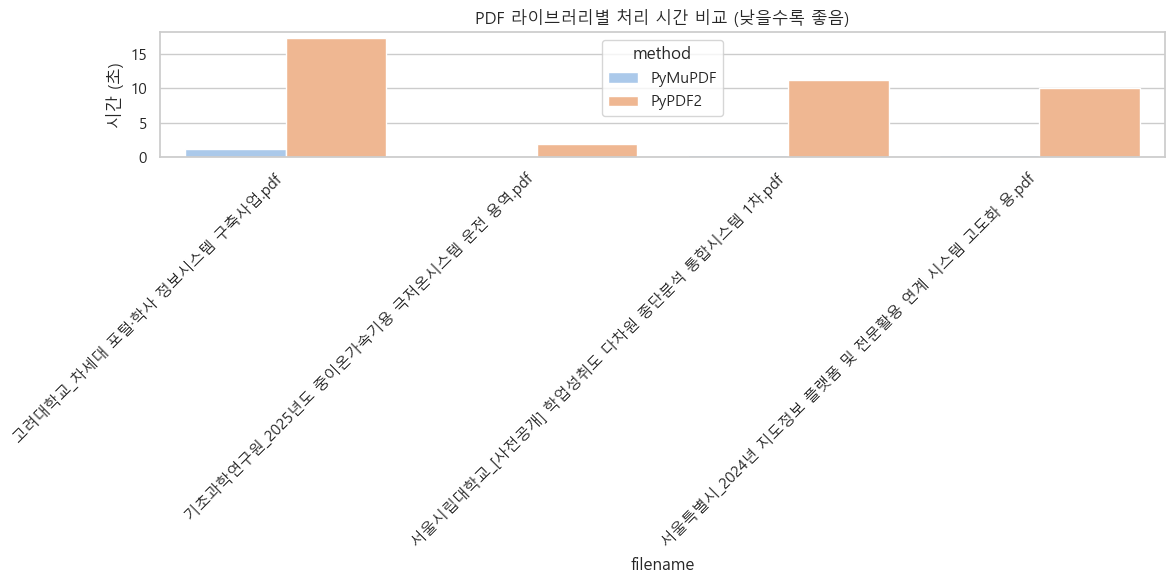

In [3]:
results = []
sample_files = pdf_files[:5]  # 테스트용 5개 파일

for path in sample_files:
    # OS별 자음모음 깨짐 해결 (NFC 정규화)
    filename = unicodedata.normalize('NFC', os.path.basename(path))
    
    # 1. pdfplumber (가용 시)
    if pdfplumber:
        res_plum = analyze_with_pdfplumber(path)
        res_plum['filename'] = filename
        results.append(res_plum)
    
    # 2. PyMuPDF (가용 시)
    if fitz:
        res_mu = analyze_with_pymupdf(path)
        res_mu['filename'] = filename
        results.append(res_mu)
    
    # 3. PyPDF2 (가용 시)
    if PdfReader:
        res_pypdf = analyze_with_pypdf2(path)
        res_pypdf['filename'] = filename
        results.append(res_pypdf)

if results:
    df_bench = pd.DataFrame(results)
    print("=== 라이브러리별 성능 비교 Sample ===")
    display(df_bench[['filename', 'method', 'page_count', 'char_count', 'duration']])

    # 시각화: 속도 비교
    plt.figure(figsize=(12, 6))
    chart = sns.barplot(x='filename', y='duration', hue='method', data=df_bench)
    chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
    plt.title('PDF 라이브러리별 처리 시간 비교 (낮을수록 좋음)')
    plt.ylabel('시간 (초)')
    plt.tight_layout() # 라벨 잘림 방지
    plt.show()
else:
    print("분석된 결과가 없습니다. 라이브러리 설치 상태를 확인해주세요.")

## 3. 전체 PDF 심층 분석 (using PyMuPDF)
가장 빠른 라이브러리(PyMuPDF)를 사용하여 전체 PDF 파일에 대한 상세 분석을 수행합니다.
**분석 항목:** 파일 크기, 페이지 수, 글자 수, 이미지 수, 특정 키워드 출현 여부

In [4]:
if fitz is None:
    print("PyMuPDF가 설치되지 않아 심층 분석을 수행할 수 없습니다.")
else:
    full_results = []

    # 분석할 키워드
    KEYWORDS = ['입찰', '제안', '예산', 'SW', 'AI', '클라우드']

    print("전체 파일 심층 분석 시작...")
    for i, path in enumerate(pdf_files[:50]):  # 시간상 50개만 수행
        try:
            # OS별 자음모음 깨짐 해결 (NFC 정규화)
            filename = unicodedata.normalize('NFC', os.path.basename(path))
            file_size = os.path.getsize(path) # 파일 크기 추출
            
            doc = fitz.open(path)
            
            # 1. 기본 메타데이터
            page_count = len(doc)
            full_text = ""
            image_count = 0
            
            for page in doc:
                full_text += page.get_text()
                image_count += len(page.get_images())
            
            # 2. 키워드 빈도 추출
            keyword_counts = {k: full_text.count(k) for k in KEYWORDS}
            
            info = {
                'filename': filename,
                'file_size_bytes': file_size,
                'file_size_kb': round(file_size / 1024, 1),
                'page_count': page_count,
                'char_count': len(full_text),
                'image_count': image_count,
                **keyword_counts  # 키워드별 카운트 컬럼 추가
            }
            full_results.append(info)
            doc.close()
            
        except Exception as e:
            print(f"Error parsing {filename}: {e}")

    df_full = pd.DataFrame(full_results)

    print(f"\n총 {len(df_full)}개 PDF 분석 완료")
    display(df_full.head())

전체 파일 심층 분석 시작...
MuPDF error: syntax error: invalid key in dict

MuPDF error: syntax error: invalid key in dict


총 4개 PDF 분석 완료


,filename,file_size_bytes,file_size_kb,page_count,char_count,image_count,입찰,제안,예산,SW,AI,클라우드
0,고려대학교_차세대 포털·학사 정보시스템 구축사업.pdf,7260060,7089.9,297,232366,333,79,178,10,7,17,0
1,기초과학연구원_2025년도 중이온가속기용 극저온시스템 운전 용역.pdf,642123,627.1,49,45562,21,1,2,0,0,0,0
2,서울시립대학교_[사전공개] 학업성취도 다차원 종단분석 통합시스템 1차.pdf,2252252,2199.5,149,116224,19,190,249,2,17,1,15
3,서울특별시_2024년 지도정보 플랫폼 및 전문활용 연계 시스템 고도화 용.pdf,3194810,3119.9,75,119899,43,154,228,4,60,0,7


## 4. 분석 결과 시각화
문서들의 특성을 시각화합니다.

C:\Users\아름\AppData\Local\Temp\ipykernel_5068\2150367060.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=keyword_sums.values, y=keyword_sums.index, palette='magma')


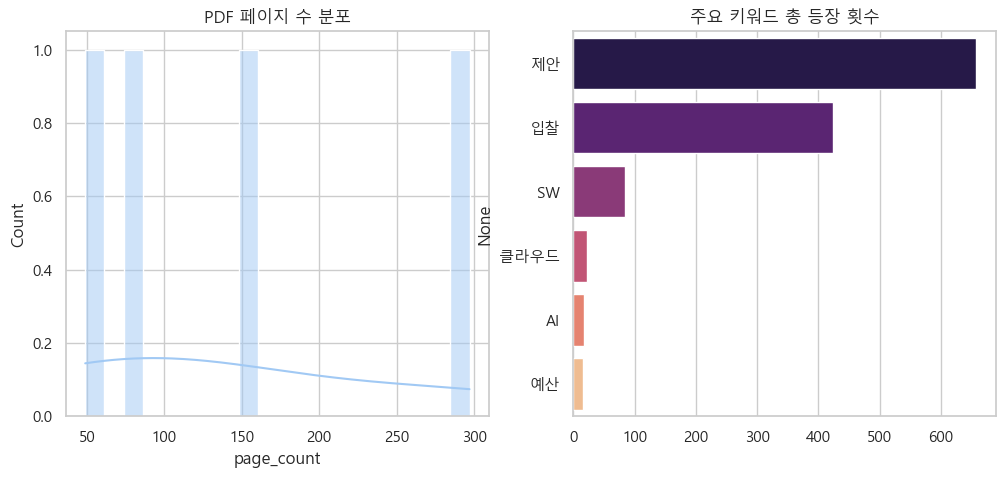

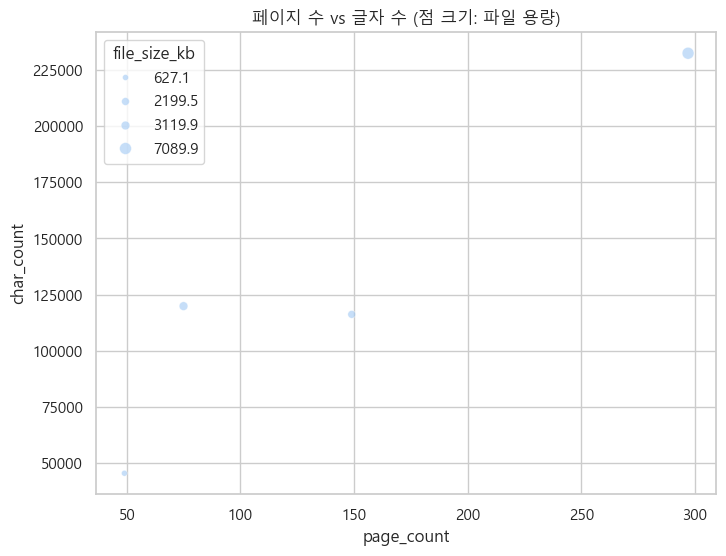

In [5]:
if 'df_full' in locals() and not df_full.empty:
    # 4.1 페이지 수 분포
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(df_full['page_count'], kde=True, bins=20)
    plt.title('PDF 페이지 수 분포')

    # 4.2 키워드 출현 빈도 (전체 문서 합계)
    plt.subplot(1, 2, 2)
    keyword_sums = df_full[KEYWORDS].sum().sort_values(ascending=False)
    sns.barplot(x=keyword_sums.values, y=keyword_sums.index, palette='magma')
    plt.title('주요 키워드 총 등장 횟수')
    plt.show()

    # 4.3 페이지 수 vs 글자 수 상관관계
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df_full, x='page_count', y='char_count', alpha=0.6, size='file_size_kb')
    plt.title('페이지 수 vs 글자 수 (점 크기: 파일 용량)')
    plt.show()
else:
    print("시각화할 데이터가 없습니다.")